In [80]:
## First we'll need to setup our environment with the necessary imports

# Basic imports
import numpy as np 
import pandas as pd
import os
from os import path


# Viz imports
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from string import punctuation
import re,string,unicodedata

# Model imports
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

# Neural Net imports
import keras
from keras.layers import Dense,LSTM
from keras.models import Sequential

In [26]:
df = pd.read_csv("Musical_instruments_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [27]:
df.shape

(10261, 9)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [29]:
df.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

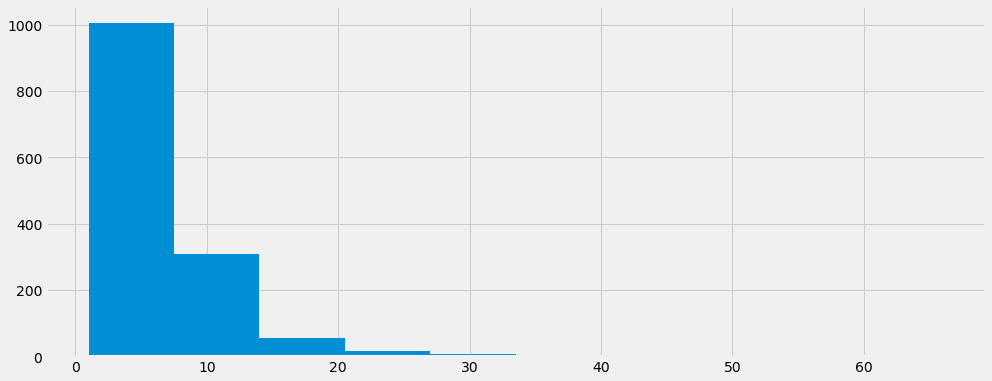

In [45]:
df.reviewerName.value_counts().hist()

In [46]:
# # Drop columns we won't be using
# df.drop(['reviewerID', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

# # Fix the naming convention for each of the remaining columns
# df = df.rename(columns={"asin": "product_id", 'reviewText': 'product_review', 'overall':'rating'})

# # Drop rows with missing values
# df.isnull().sum().sort_values(ascending=False)
# df = df.dropna()

# df.head()

# Create a full picture of all the relevant text associated with each review
df['full_review'] = df['reviewText'] + ' ' + df['summary']

# Create a feature that gives us a length of each review
df['review_length'] = len(df.full_review)

# Drop columns we won't be using
df.drop(['reviewerID', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

# Fix the naming convention for each of the remaining columns
df = df.rename(columns={"asin": "product_id", 'reviewText': 'product_review', 'overall':'rating'})

# Drop rows with missing values
df.isnull().sum().sort_values(ascending=False)
df = df.dropna()

df.head()

,product_id,product_review,rating,summary,full_review,review_length
0,1384719342,"Not much to write about here, but it does exac...",5.0,good,"Not much to write about here, but it does exac...",10261
1,1384719342,The product does exactly as it should and is q...,5.0,Jake,The product does exactly as it should and is q...,10261
2,1384719342,The primary job of this device is to block the...,5.0,It Does The Job Well,The primary job of this device is to block the...,10261
3,1384719342,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,10261
4,1384719342,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,10261


In [47]:
# Create a full picture of all the relevant text associated with each review

df['text'] = df['product_review'] + ' ' + df['summary']
del df['product_review']
del df['summary']

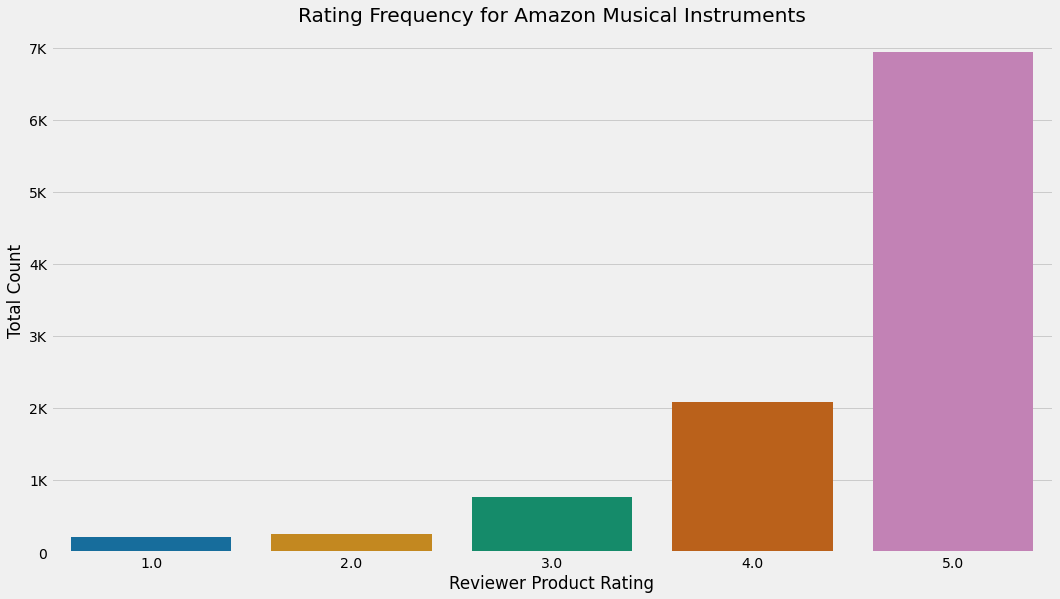

In [83]:
plt.figure(figsize=(16, 9))
plt.style.use('fivethirtyeight')
sns.countplot(df['rating'], data=df, palette='colorblind')
plt.title('Rating Frequency for Amazon Musical Instruments')
plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000], ['0', '1K', '2K', '3K', '4K', '5K', '6K', '7K'])
plt.ylabel('Total Count')
plt.xlabel('Reviewer Product Rating')
plt.show()

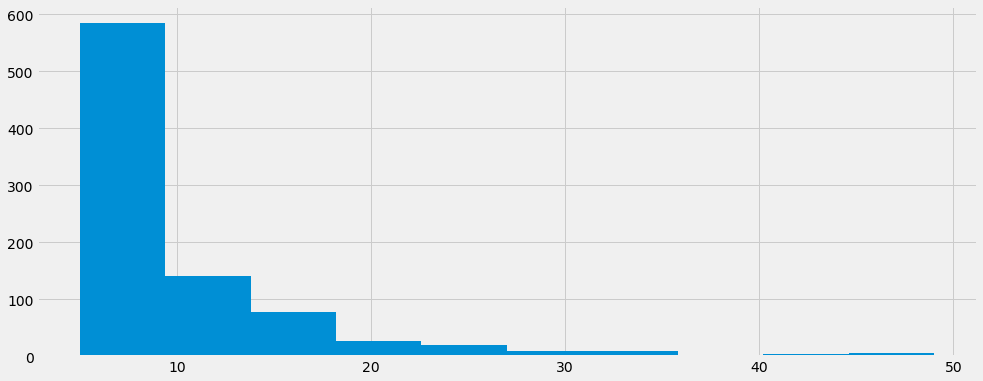

In [64]:
df.product_id.value_counts()[20:].hist()

In [63]:
top_20 = df['product_id'].value_counts()[:20]
top_20

B003VWJ2K8    163
B0002E1G5C    143
B0002F7K7Y    116
B003VWKPHC    114
B0002H0A3S     93
B0002CZVXM     74
B0006NDF8A     71
B0009G1E0K     69
B0002E2KPC     68
B0002GLDQM     67
B004XNK7AI     65
B00646MZHK     62
B005FKF1PY     62
B0002GMGYA     58
B001PGXHX0     58
B0018TIADQ     57
B000978D58     57
B001PGXKC8     55
B0002D0CEO     55
B000068NW5     52
Name: product_id, dtype: int64

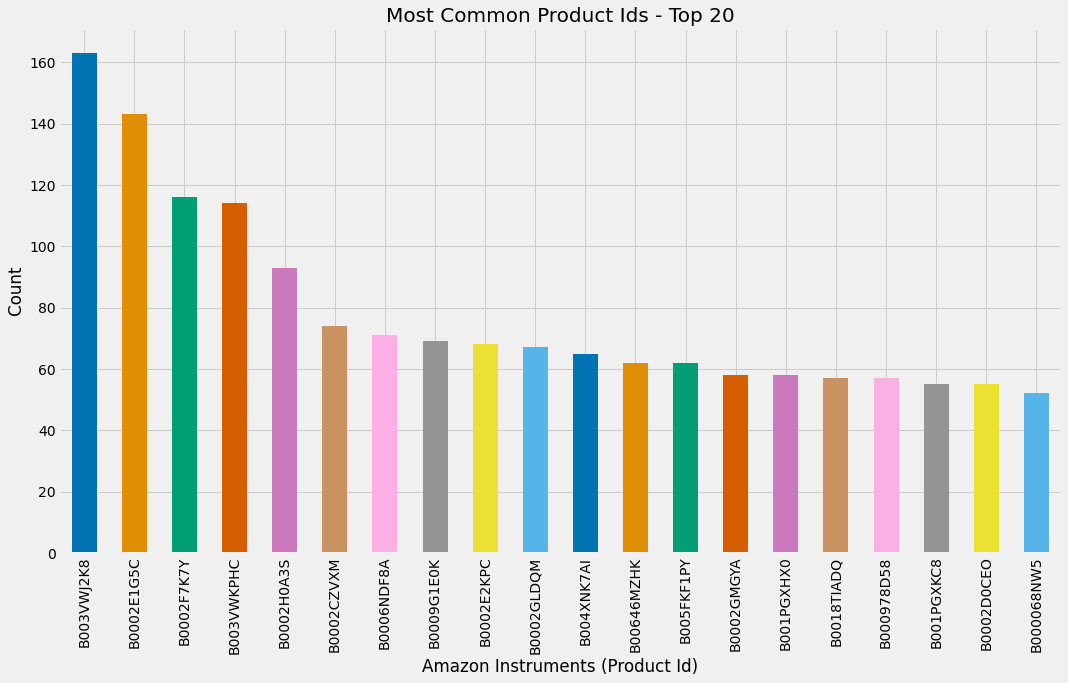

In [54]:
color_pal = sns.color_palette("colorblind")
plt.figure(figsize=(16, 9))
plt.style.use('fivethirtyeight')
top_20 = df['product_id'].value_counts()[:20]
top_20.plot.bar(color=color_pal)
#sns.countplot(df['rating'], data=df, palette='colorblind')
plt.title('Most Common Product Ids - Top 20', fontsize = 20)
plt.xlabel('Amazon Instruments (Product Id)')
plt.ylabel('Count')
plt.show()

In [68]:
def clean(text: str) -> list:
    'A simple function to cleanup text data'
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [69]:
corpus = clean(' '.join(df.full_review))

In [70]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

#w = corpus

corpus_str = listToString(corpus)

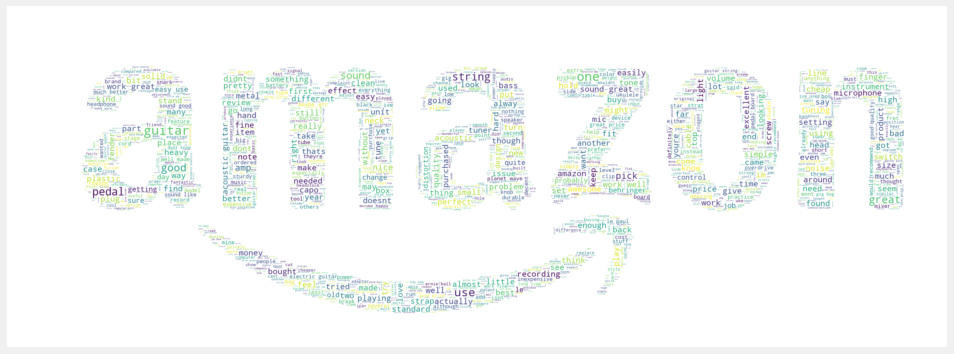

<Figure size 1080x432 with 0 Axes>

In [81]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
#text = ham_str

# read the mask / color image taken from
# http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
coloring = np.array(Image.open(path.join(d, "Amazon-logo.jpg")))
stopwords = set(STOPWORDS)
#stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
# generate word cloud
wc.generate(corpus_str)

# create coloring from image
image_colors = ImageColorGenerator(coloring)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

## Modeling

In [85]:
df.head()

,product_id,rating,full_review,review_length,text
0,1384719342,5.0,"Not much to write about here, but it does exac...",10261,"Not much to write about here, but it does exac..."
1,1384719342,5.0,The product does exactly as it should and is q...,10261,The product does exactly as it should and is q...
2,1384719342,5.0,The primary job of this device is to block the...,10261,The primary job of this device is to block the...
3,1384719342,5.0,Nice windscreen protects my MXL mic and preven...,10261,Nice windscreen protects my MXL mic and preven...
4,1384719342,5.0,This pop filter is great. It looks and perform...,10261,This pop filter is great. It looks and perform...


In [86]:
df.rating.value_counts()

5.0    6932
4.0    2083
3.0     772
2.0     250
1.0     217
Name: rating, dtype: int64

In [87]:
# Let's make a binary sentiment encoder

def sentiment(rating):
    # Replacing ratings of 1,2,3 with 0 (not good) and 4,5 with 1 (good)
    if(int(rating) == 1 or int(rating) == 2 or int(rating) == 3):
        return 0
    else: 
        return 1
    
# Add a new column to the dataframe with this encoded sentiment
df['rating_sentiment'] = df.rating.apply(sentiment) 

In [89]:
df.rating_sentiment.value_counts()

1    9015
0    1239
Name: rating_sentiment, dtype: int64